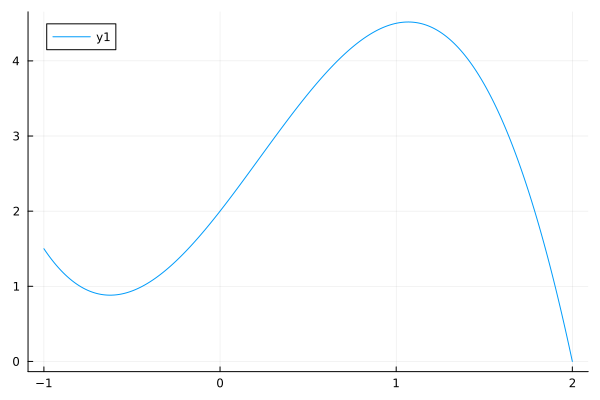

In [10]:
using LinearAlgebra
using Plots
using Random

function f(x, θ)
    powers = x.^(0:(length(θ)-1))
    return dot(powers, θ)
end

ts = -1.0:0.01:2.0
params = [2.0, 3.0, 1.0, -1.5]
ys = [f(t, params) for t in ts]
plot(ts, ys)

Funkcja celu:
$$
f_{cost}(\theta) = \sum_{i=1}^{N} (f(x_i; \theta) - y_i)^2
$$

Gradient funkcji celu:
$$
\nabla f_{cost}(\theta) = \sum_{i=1}^{N} 2(f(x_i; \theta) - y_i) \nabla f(x_i; \theta)
$$

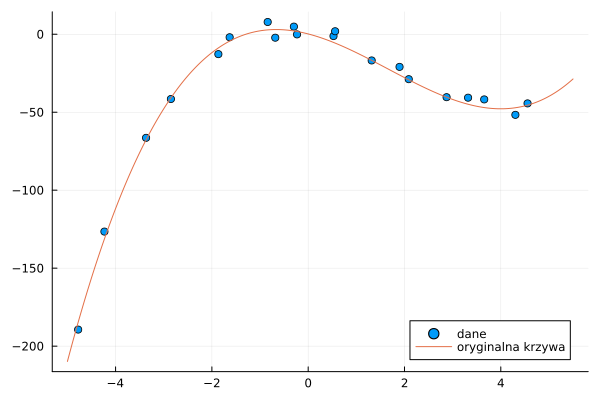

In [11]:
# Przykładowe dane
Random.seed!(15)
x_data = sort(randn(20).*3)
θ_data = [0.2, -8.0, -5.0, 1]
y_data = [f(x, θ_data) + randn()*4.0 for x in x_data]
scatter(x_data, y_data; label="dane")
t_plot = -5:0.01:5.5
plot!(t_plot, [f(x, θ_data) for x in t_plot]; label="oryginalna krzywa")

In [12]:

struct CostF
    cost_x::Vector{Float64}
    cost_y::Vector{Float64}
end
(cf::CostF)(θ) = sum((map(x -> f(x, θ), cf.cost_x) - y_data).^2)

struct GradF
    cost_x::Vector{Float64}
    cost_y::Vector{Float64}
end
function (gf::GradF)(storage, θ)
    storage .= 0
    for i in eachindex(gf.cost_x)
        x = gf.cost_x[i]
        powers = x.^(0:(length(θ)-1))
        storage .+= 2 .* (dot(powers, θ) - gf.cost_y[i]) .* powers
    end
    return storage
end

cost_data = CostF(x_data, y_data)
grad_data = GradF(x_data, y_data)


GradF([-4.777076232810082, -4.231641260013276, -3.36664693050746, -2.850947162519062, -1.8652592004392048, -1.6309695930194554, -0.84111100753486, -0.683650954243644, -0.2969787822260413, -0.2312491356269601, 0.5258648142813602, 0.5594361248923817, 1.3184807897701973, 1.8972233960903897, 2.0883287944510935, 2.8740461010485854, 3.320583358000931, 3.655715832267388, 4.303221121210904, 4.55584294410259], [-189.38454471808805, -126.53917341405467, -66.41467357645297, -41.52394197698426, -12.758214896774886, -1.9283368351326926, 7.858207526351018, -2.2159407401451823, 4.896484922745821, -0.09751347311553449, -1.1713880559965153, 1.9240819751783764, -16.804117059721772, -20.92313053452344, -28.817083226932333, -40.35742636247607, -40.68132623192331, -41.785701182207134, -51.6827041858641, -44.3415044915719])

In [ ]:
using Optim
using LineSearches
println(cost_data(randn(4)))


optim_res = optimize(cost_data, grad_data, randn(4), ConjugateGradient())

In [14]:
println("Znalezione wartości: $(optim_res.minimizer)")
println("Funkja kosztu dla znalezionych: $(optim_res.minimum)")
println("Oryginalne wartości:  $(θ_data)")
println("Funkcja kosztu dla oryginalnych wartości: $(cost_data(θ_data))")

scatter(x_data, y_data; label="dane")
t_plot = -5:0.01:5.5
plot!(t_plot, [f(x, θ_data) for x in t_plot]; label="oryginalna krzywa")
plot!(t_plot, [f(x, optim_res.minimizer) for x in t_plot]; label="optymalna krzywa")

UndefVarError: UndefVarError: `optim_res` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

### Zadanie:

1. Napisz funkcję optymalizującą realizującą metodę największego spadku ze stałym krokiem. Spróbuj dobrać krok tak, aby problem regresji został rozwiązany w miarę dokładnie. Czy się udało?
2. Zamień stały krok na krok zanikający, t.j.
$$
\begin{align*}
\alpha_1 &= 1 \\
\alpha_k &= \gamma \alpha_{k-1}
\end{align*}
$$
dla pewnej stałej $\gamma \in (0,1]$, np. $\gamma = 0.9$ i porównaj działanie.

In [15]:

opt = my_optimize(cost_data, grad_data, randn(4))
println(opt, cost_data(opt))
println("Cost = $(cost_data(opt))")

UndefVarError: UndefVarError: `my_optimize` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

Skąd wiedzieć, czy nasz gradient jest poprawny?
Możemy wykonać test.

In [17]:
using Manopt, Manifolds
(cf::CostF)(::Euclidean, θ) = cf(θ)
(gf::GradF)(::Euclidean, θ) = gf(similar(θ), θ)
check_gradient(Euclidean(4), cost_data, grad_data, plot=true)

ArgumentError: ArgumentError: Package Manopt not found in current path.
- Run `import Pkg; Pkg.add("Manopt")` to install the Manopt package.